In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
import fastai.callbacks.hooks
import re

In [3]:
path = Path("shoes")

In [4]:
def extractSubclass(f):
    pat = r"shoes\\ut-zap50k-images-square\\([^\\]+\\[^\\]+)\\.*"
    m = re.match(pat,str(f))
    return m.group(1)

In [5]:
src = (ImageItemList.from_folder(path)
        #.filter_by_rand(p=0.05)
        .random_split_by_pct(0.3)
        .label_from_func(extractSubclass))

In [6]:
tfms = get_transforms()
data = src.transform(tfms,size=136).databunch(bs=16,num_workers=0).normalize(imagenet_stats)

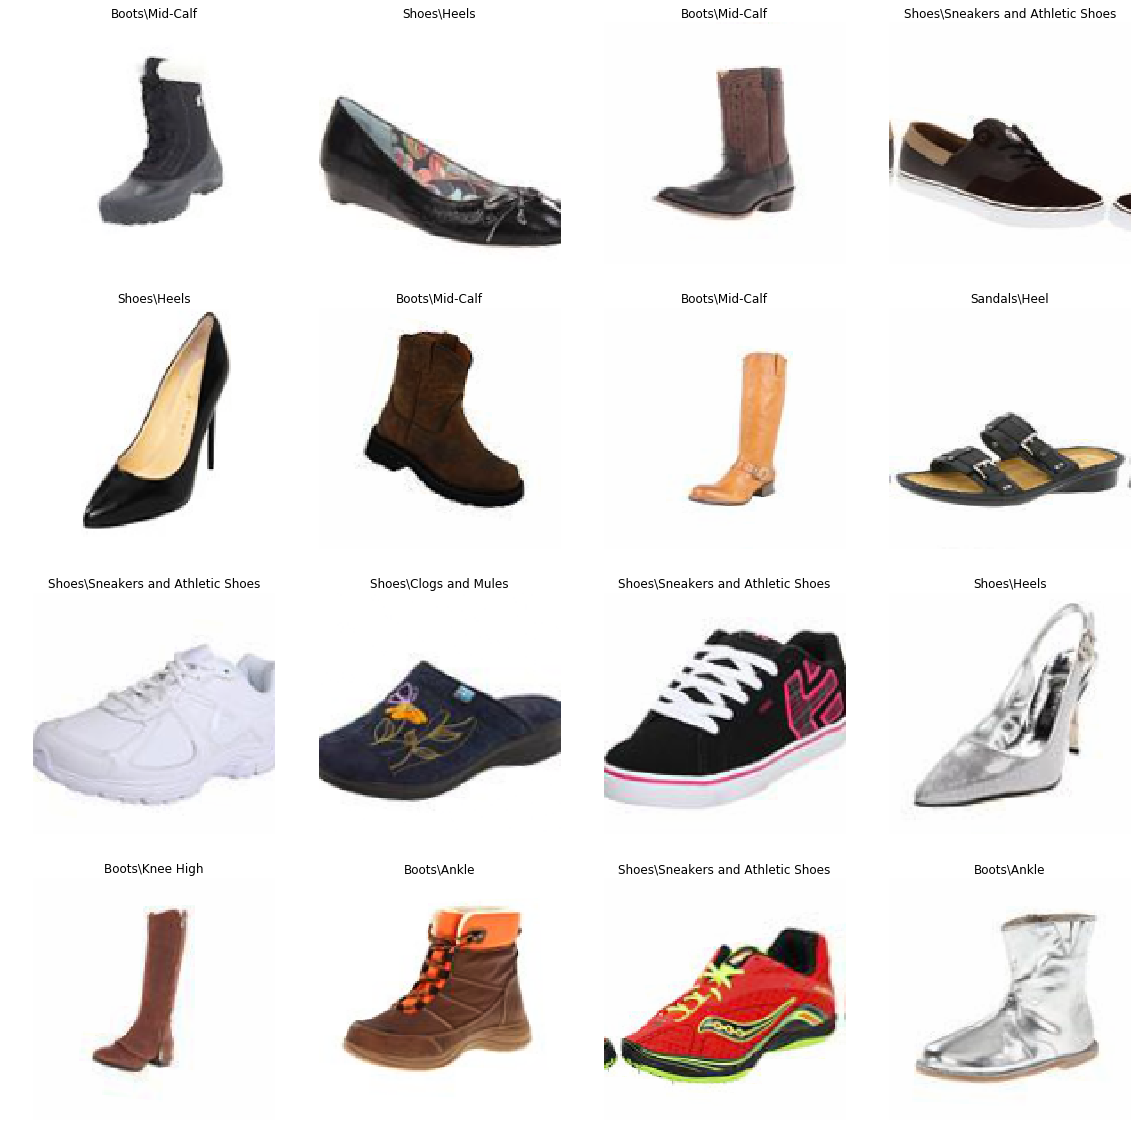

In [7]:
data.show_batch()

In [9]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,width=8,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(conv2d(3, 8*width, ks=11, stride=4, padding=2,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(conv2d(8*width + 64, 24 * width, ks=5, padding=2,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(conv2d(24*width + 192, 48 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True)),
            nn.Sequential(conv2d(48*width + 384, 32 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True)),
            nn.Sequential(conv2d(32*width + 256, 32 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])
        
        self.classifier = create_head((32*width + 256)*2,num_classes)

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        x = self.classifier(x)
        return x


In [10]:
learn = create_cnn(data,models.alexnet,metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03


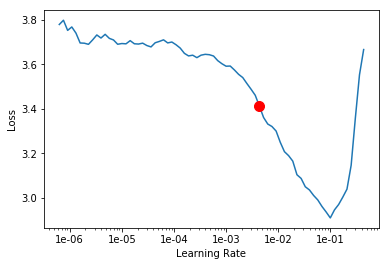

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.freeze()

In [12]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.164152,0.878463,0.712298
2,1.181854,0.928991,0.698315
3,1.208427,0.940371,0.692922
4,1.217085,0.925793,0.698582
5,1.129403,0.902418,0.709435
6,1.204592,0.844978,0.729077
7,1.041878,0.827113,0.733804
8,1.008224,0.790072,0.745589
9,1.048564,0.780532,0.746854
10,0.993677,0.784891,0.745389


In [13]:
learn.unfreeze()
learn.fit_one_cycle(20,1e-5)

epoch,train_loss,valid_loss,accuracy
1,0.969976,0.761033,0.751981
2,0.830753,0.710634,0.765164
3,0.820631,0.667395,0.777349
4,0.776157,0.633340,0.788202
5,0.755020,0.604072,0.798256
6,0.738893,0.579157,0.807178
7,0.656557,0.554662,0.814635
8,0.673260,0.545985,0.816233
9,0.662497,0.537381,0.818563
10,0.618667,0.524671,0.823690


In [14]:
learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=8),metrics=[accuracy])
learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])

In [80]:
learnSK.model(next(iter(data.train_dl))[0]).shape

torch.Size([16, 17])

In [15]:
learnSK.freeze_to(1)

In [16]:
learnSK.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.865478,0.709114,0.776217
2,0.780594,0.598198,0.805247
3,0.734366,0.827932,0.815367
4,0.639879,0.507095,0.829749
5,0.526820,0.475091,0.838871
6,0.508242,0.451412,0.847926
7,0.482685,0.432978,0.853053
8,0.427164,0.423754,0.858046
9,0.380708,0.425096,0.861442
10,0.390294,0.426445,0.860643


In [18]:
learnSK.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.370128,0.425542,0.860177
2,0.399813,0.445209,0.862175
3,0.399370,0.434794,0.862108
4,0.380714,0.419932,0.863306
5,0.416028,0.432611,0.865038
6,0.312200,0.425460,0.864904
7,0.350981,0.445793,0.863107
8,0.373150,0.446721,0.864771
9,0.338343,0.446062,0.863906
10,0.384882,0.414664,0.864838


In [ ]:
learnSK.save("sz128")